In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [86]:
import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, image
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, Input
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
import os

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [6]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [7]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [8]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [9]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [10]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [11]:
import knifey

In [12]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [13]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [14]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

In [15]:
model = VGG16(include_top=True, weights='imagenet')

In [16]:
# from that we know input shape of the model
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [17]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range =180,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range=0.1,
                                  zoom_range=[0.9,1.5],
                                  horizontal_flip = True,
                                  vertical_flip= True,
                                  fill_mode = 'nearest')

In [18]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [19]:
if True:
    save_to_dir = None
else:
    save_to_dir = 'augmented_images'

In [31]:
batch_size = 10

In [21]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                   target_size= input_shape,
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


In [24]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                   target_size= input_shape,
                                                   batch_size = batch_size,
                                                   shuffle=False)

Found 530 images belonging to 3 classes.


In [32]:
steps_test = generator_test.n/batch_size
steps_test

53.0

In [33]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [35]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [36]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

In [39]:
num_classes = len(class_names)
num_classes

3

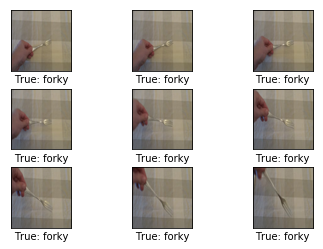

In [40]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [41]:
from sklearn.utils.class_weight import compute_class_weight

In [42]:
class_weight = compute_class_weight(class_weight='balanced',
                                   classes = np.unique(cls_train),
                                   y=cls_train)

In [43]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [72]:
import PIL
def predict(image_path):
    # load and resize image
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
    
    # show the img
    plt.imshow(img_resized)
    plt.show()
    
    # covert PIL img to np arrey
    img_arrey = np.expand_dims(np.array(img_resized), axis=0)
    
    # use of vgg16, output is 1000 classes of image net
    pred = model.predict(img_arrey)
    
    # we take only 1 prediction form output, decode
    pred_decoded = decode_predictions(pred)[0]
    
    # print prediction
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

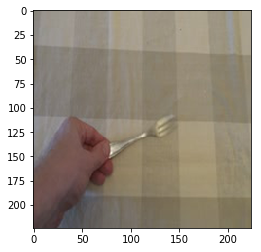

50.31% : shower_curtain
17.08% : handkerchief
12.75% : mosquito_net
 2.87% : window_shade
 1.32% : toilet_tissue


In [74]:
PATH = image_paths_train[0]
predict(PATH)

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [76]:
transfer_layer = model.get_layer('block5_pool')

In [77]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [78]:
conv_model = Model(inputs= model.input, outputs = transfer_layer.output)

In [84]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(num_classes, activation='softmax'))

In [92]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [93]:
print_layer_trainable()

False:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [96]:
# we set layer to trainable false 
for layer in conv_model.layers:
    layer.trainable = False

In [97]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [100]:
epochs = 20
steps_per_epoch = 100
opti= Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metric = ['categorical_accuracy']

In [101]:
new_model.compile(optimizer=opti, loss=loss, metrics=metric)

In [103]:
%%time
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 21s 207ms/step - loss: 0.5572 - categorical_accuracy: 0.7630 - val_loss: 0.5347 - val_categorical_accuracy: 0.7811
Epoch 2/20
100/100 [==============================] - 19s 193ms/step - loss: 0.5291 - categorical_accuracy: 0.7810 - val_loss: 0.7272 - val_categorical_accuracy: 0.6472
Epoch 3/20
100/100 [==============================] - 19s 194ms/step - loss: 0.5440 - categorical_accuracy: 0.7770 - val_loss: 0.5979 - val_categorical_accuracy: 0.7434
Epoch 4/20
100/100 [==============================] - 19s 195ms/step - loss: 0.5414 - categorical_accuracy: 0.7660 - val_loss: 0.7737 - val_categorical_accuracy: 0.6415
Epoch 5/20
100/100 [==============================] - 21s 205ms/step - loss: 0.5133 - categorical_accuracy: 0.7820 - val_loss: 0.6451 - val_categorical_accuracy: 0.7132
Epoch 6/20
100/100 [==============================] - 19s 191ms/step - loss: 0.5306 - categorical_accuracy: 0.7760 - val_loss: 0.7509 - val_categorical_acc

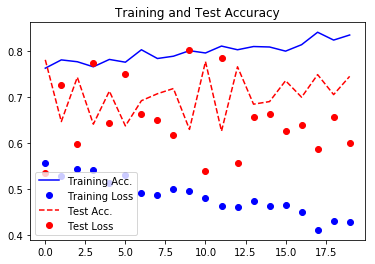

In [104]:
plot_training_history(history)

In [105]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [106]:
print(format(result[1]))

0.7452830171810007


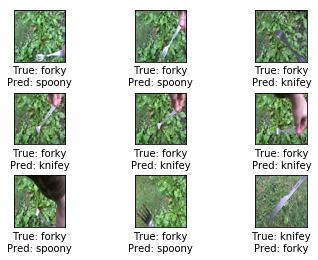

Confusion matrix:
[[143   4   4]
 [ 48  89   0]
 [ 62  17 163]]
(0) forky
(1) knifey
(2) spoony


In [107]:
example_errors()

In [108]:
conv_model.trainable =True

In [109]:
for layer in conv_model.layers:
    trainable = ('block5'in layer.name or 'block4' in layer.name)
    layer.trainable = trainable

In [111]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [112]:
opti_fine = Adam(lr=1e-7)

In [113]:
new_model.compile(optimizer=opti_fine, loss=loss, metrics=metric)

In [114]:
%%time
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 28s 278ms/step - loss: 0.4267 - categorical_accuracy: 0.8180 - val_loss: 0.6038 - val_categorical_accuracy: 0.7302
Epoch 2/20
100/100 [==============================] - 26s 257ms/step - loss: 0.4102 - categorical_accuracy: 0.8420 - val_loss: 0.6170 - val_categorical_accuracy: 0.7189
Epoch 3/20
100/100 [==============================] - 25s 253ms/step - loss: 0.4475 - categorical_accuracy: 0.8030 - val_loss: 0.6079 - val_categorical_accuracy: 0.7245
Epoch 4/20
100/100 [==============================] - 24s 243ms/step - loss: 0.4272 - categorical_accuracy: 0.8280 - val_loss: 0.5895 - val_categorical_accuracy: 0.7340
Epoch 5/20
100/100 [==============================] - 25s 247ms/step - loss: 0.4046 - categorical_accuracy: 0.8410 - val_loss: 0.5855 - val_categorical_accuracy: 0.7396
Epoch 6/20
100/100 [==============================] - 24s 238ms/step - loss: 0.4282 - categorical_accuracy: 0.8310 - val_loss: 0.5800 - val_categorical_acc

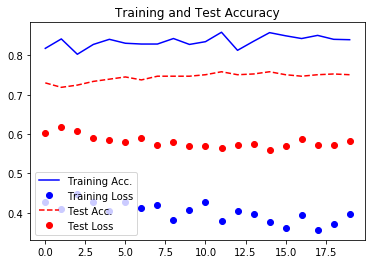

In [115]:
plot_training_history(history)


In [116]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 38,673,411
Non-trainable params: 1,735,488
_________________________________________________________________


In [118]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [119]:
print(format(result[1]))

0.7509433919528745


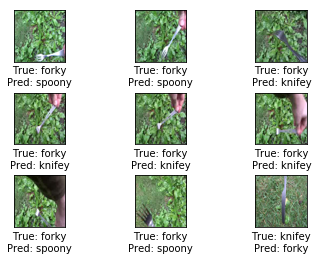

Confusion matrix:
[[143   4   4]
 [ 56  81   0]
 [ 59   9 174]]
(0) forky
(1) knifey
(2) spoony


In [120]:
example_errors()